In [69]:
import torch, torchvision
print(f'PyTorch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}')

PyTorch version: 2.7.1+cu118
Torchvision version: 0.22.1+cu118


## 1. Import thư viện

In [70]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## 2. Cấu hình đường dẫn dữ liệu

In [71]:
# MNIST paths
MNIST_TRAIN_DIR = 'mnist_competition/train'
MNIST_TEST_DIR = 'mnist_competition/public_test'
MNIST_TRAIN_CSV = 'mnist_competition/train_label.csv'
MNIST_TEST_CSV = 'mnist_competition/public_test.csv'

# Shapes paths
SHAPES_DIR = '2D_Geometric_Shapes_Dataset'

# Shape classes
SHAPE_CLASSES = ['circle', 'hexagon', 'oval', 'rectangle', 'square', 'star', 'triangle']

print(f'Number of shape classes: {len(SHAPE_CLASSES)}')
print(f'Shape classes: {SHAPE_CLASSES}')

Number of shape classes: 7
Shape classes: ['circle', 'hexagon', 'oval', 'rectangle', 'square', 'star', 'triangle']


## 3. Load dữ liệu MNIST

In [72]:
mnist_train_df = pd.read_csv(MNIST_TRAIN_CSV)
mnist_test_df = pd.read_csv(MNIST_TEST_CSV)

print(f'MNIST Train samples: {len(mnist_train_df)}')
print(f'MNIST Test samples: {len(mnist_test_df)}')
print(f'\nMNIST Label distribution:')
print(mnist_train_df['label'].value_counts().sort_index())

MNIST Train samples: 60000
MNIST Test samples: 10000

MNIST Label distribution:
label
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64


## 4. Load dữ liệu Shapes

In [73]:
# Tạo dataframe cho shapes dataset
shapes_data = []

for shape_class in SHAPE_CLASSES:
    shape_dir = os.path.join(SHAPES_DIR, shape_class)
    if os.path.exists(shape_dir):
        for img_name in os.listdir(shape_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                shapes_data.append({
                    'image_path': os.path.join(shape_dir, img_name),
                    'label': shape_class,
                    'label_idx': SHAPE_CLASSES.index(shape_class)
                })

shapes_df = pd.DataFrame(shapes_data)

print(f'Total shapes samples: {len(shapes_df)}')
print(f'\nShapes distribution:')
print(shapes_df['label'].value_counts().sort_index())

Total shapes samples: 350000

Shapes distribution:
label
circle       50000
hexagon      50000
oval         50000
rectangle    50000
square       50000
star         50000
triangle     50000
Name: count, dtype: int64


## 5. Visualize dữ liệu

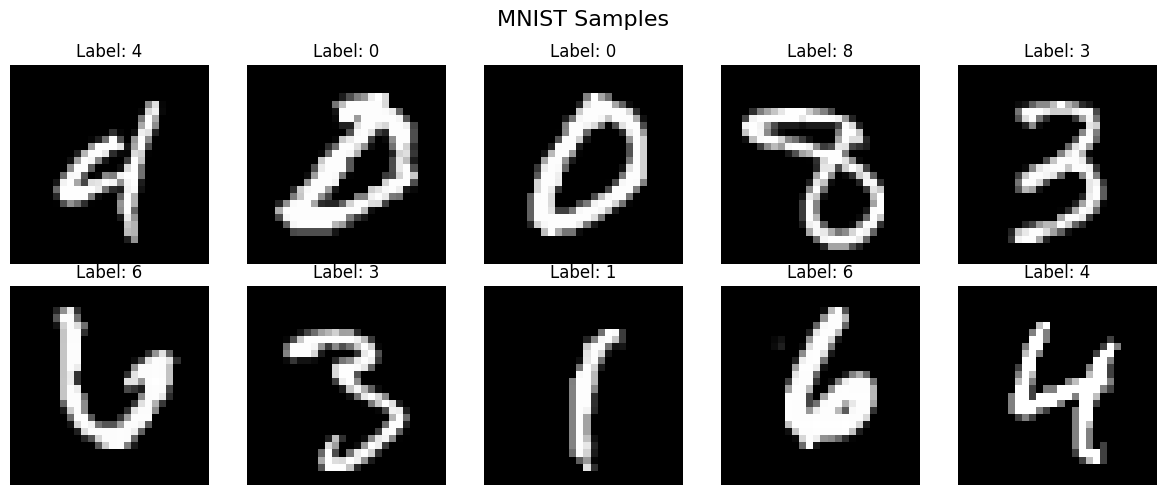

In [74]:
# Visualize MNIST
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('MNIST Samples', fontsize=16)
axes = axes.ravel()

for i in range(10):
    idx = np.random.randint(len(mnist_train_df))
    img_name = mnist_train_df.iloc[idx]['image_name']
    label = mnist_train_df.iloc[idx]['label']
    
    img_path = os.path.join(MNIST_TRAIN_DIR, img_name)
    img = Image.open(img_path)
    
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

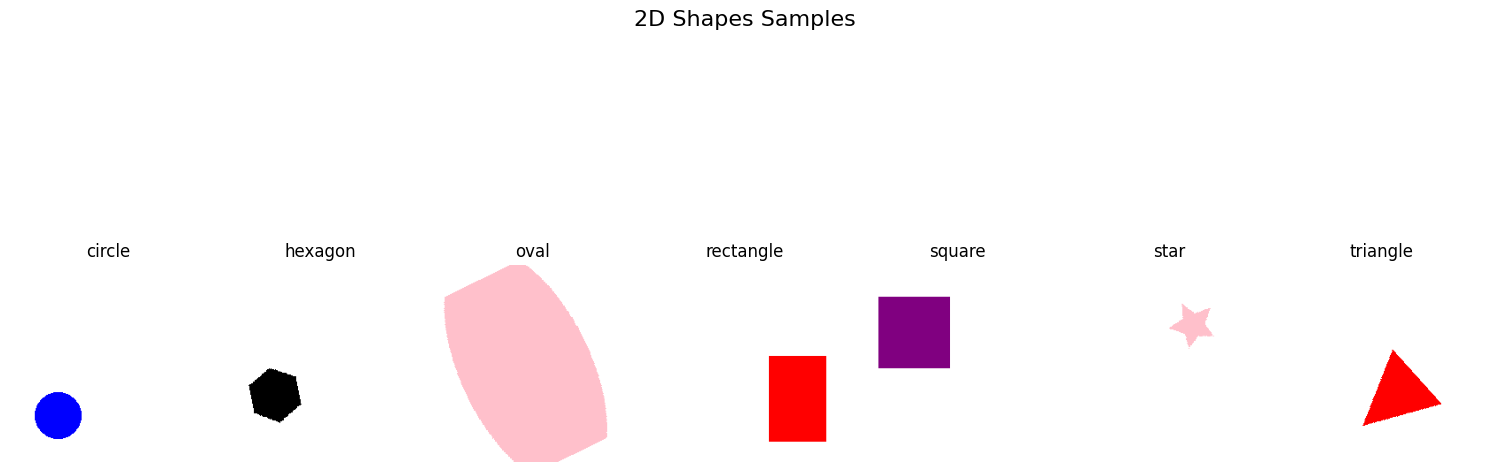

In [78]:
# Visualize Shapes
fig, axes = plt.subplots(1, 7, figsize=(15, 7))
fig.suptitle('2D Shapes Samples', fontsize=16)
axes = axes.ravel()

for i, shape_class in enumerate(SHAPE_CLASSES):
    shape_samples = shapes_df[shapes_df['label'] == shape_class]
    if len(shape_samples) > 0:
        idx = np.random.randint(len(shape_samples))
        img_path = shape_samples.iloc[idx]['image_path']
        img = Image.open(img_path)
        
        axes[i].imshow(img)
        axes[i].set_title(f'{shape_class}')
        axes[i].axis('off')

# Hide extra subplot
axes[6].axis('off')

plt.tight_layout()
plt.show()

## 6. Tạo Dataset Classes

In [79]:
class MNISTDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image_name']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image, img_name
        else:
            label = self.df.iloc[idx]['label']
            return image, label


class ShapesDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label_idx']
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

## 7. Chuẩn bị Data Loaders
### 7.1 MNIST Data Loaders

In [80]:
mnist_train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train_split, mnist_val_split = train_test_split(
    mnist_train_df, test_size=0.1, random_state=42, stratify=mnist_train_df['label']
)

print(f'MNIST Train size: {len(mnist_train_split)}')
print(f'MNIST Validation size: {len(mnist_val_split)}')

mnist_train_dataset = MNISTDataset(mnist_train_split, MNIST_TRAIN_DIR, transform=mnist_train_transform)
mnist_val_dataset = MNISTDataset(mnist_val_split, MNIST_TRAIN_DIR, transform=mnist_test_transform)
mnist_test_dataset = MNISTDataset(mnist_test_df, MNIST_TEST_DIR, transform=mnist_test_transform, is_test=True)

BATCH_SIZE = 64

mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
mnist_val_loader = DataLoader(mnist_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

MNIST Train size: 54000
MNIST Validation size: 6000


### 7.2 Shapes Data Loaders

In [81]:
shapes_train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

shapes_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

shapes_train_split, shapes_val_split = train_test_split(
    shapes_df, test_size=0.15, random_state=42, stratify=shapes_df['label']
)

print(f'Shapes Train size: {len(shapes_train_split)}')
print(f'Shapes Validation size: {len(shapes_val_split)}')

shapes_train_dataset = ShapesDataset(shapes_train_split, transform=shapes_train_transform)
shapes_val_dataset = ShapesDataset(shapes_val_split, transform=shapes_test_transform)

shapes_train_loader = DataLoader(shapes_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
shapes_val_loader = DataLoader(shapes_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Shapes Train size: 297500
Shapes Validation size: 52500


## 8. Định nghĩa Models
### 8.1 MNIST Model (Grayscale, 1 channel)

In [82]:
class MNISTModel(nn.Module):
    def __init__(self, num_classes=10):
        super(MNISTModel, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

mnist_model = MNISTModel(num_classes=10).to(device)
print('MNIST Model:')
print(mnist_model)
mnist_params = sum(p.numel() for p in mnist_model.parameters())
print(f'Total parameters: {mnist_params:,}')

MNIST Model:
MNISTModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)
Total parameters: 390,410


### 8.2 Shapes Model (RGB, 3 channels)

In [83]:
class ShapesModel(nn.Module):
    def __init__(self, num_classes=7):
        super(ShapesModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

shapes_model = ShapesModel(num_classes=7).to(device)
print('\nShapes Model:')
print(shapes_model)
shapes_params = sum(p.numel() for p in shapes_model.parameters())
print(f'Total parameters: {shapes_params:,}')


Shapes Model:
ShapesModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
  (relu): ReLU()
)
Total parameters: 2,489,671


## 9. Training Functions

In [84]:
def train_epoch(model, loader, criterion, optimizer, device, desc='Training'):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc=desc)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': running_loss / (pbar.n + 1), 'acc': 100. * correct / total})
    
    return running_loss / len(loader), 100. * correct / total


def validate(model, loader, criterion, device, desc='Validation'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc=desc)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': running_loss / (pbar.n + 1), 'acc': 100. * correct / total})
    
    return running_loss / len(loader), 100. * correct / total

## 10. Train MNIST Model

In [85]:
mnist_criterion = nn.CrossEntropyLoss()
mnist_optimizer = optim.Adam(mnist_model.parameters(), lr=0.001)
mnist_scheduler = optim.lr_scheduler.ReduceLROnPlateau(mnist_optimizer, mode='min', factor=0.5, patience=2)

NUM_EPOCHS = 10
best_mnist_acc = 0.0
mnist_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print('\n' + '='*60)
print('TRAINING MNIST MODEL')
print('='*60)

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 50)
    
    train_loss, train_acc = train_epoch(mnist_model, mnist_train_loader, mnist_criterion, 
                                        mnist_optimizer, device, desc='MNIST Training')
    val_loss, val_acc = validate(mnist_model, mnist_val_loader, mnist_criterion, 
                                 device, desc='MNIST Validation')
    
    mnist_history['train_loss'].append(train_loss)
    mnist_history['train_acc'].append(train_acc)
    mnist_history['val_loss'].append(val_loss)
    mnist_history['val_acc'].append(val_acc)
    
    mnist_scheduler.step(val_loss)
    
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    
    if val_acc > best_mnist_acc:
        best_mnist_acc = val_acc
        torch.save(mnist_model.state_dict(), 'best_mnist_model.pth')
        print(f'✓ Saved best MNIST model with validation accuracy: {val_acc:.2f}%')

print(f'\nMNIST Training completed! Best validation accuracy: {best_mnist_acc:.2f}%')


TRAINING MNIST MODEL

Epoch 1/10
--------------------------------------------------


MNIST Validation: 100%|█████████████████████████████████████████| 94/94 [00:07<00:00, 12.33it/s, loss=0.0726, acc=98.1]


Train Loss: 0.2274 | Train Acc: 92.83%
Val Loss: 0.0718 | Val Acc: 98.08%
✓ Saved best MNIST model with validation accuracy: 98.08%

Epoch 2/10
--------------------------------------------------


MNIST Validation: 100%|█████████████████████████████████████████| 94/94 [00:05<00:00, 15.86it/s, loss=0.0433, acc=98.8]


Train Loss: 0.0717 | Train Acc: 97.93%
Val Loss: 0.0428 | Val Acc: 98.77%
✓ Saved best MNIST model with validation accuracy: 98.77%

Epoch 3/10
--------------------------------------------------


MNIST Validation: 100%|██████████████████████████████████████████| 94/94 [00:06<00:00, 15.43it/s, loss=0.042, acc=98.7]


Train Loss: 0.0557 | Train Acc: 98.34%
Val Loss: 0.0416 | Val Acc: 98.73%

Epoch 4/10
--------------------------------------------------


MNIST Validation: 100%|███████████████████████████████████████████| 94/94 [00:06<00:00, 15.55it/s, loss=0.0366, acc=99]


Train Loss: 0.0459 | Train Acc: 98.60%
Val Loss: 0.0362 | Val Acc: 98.97%
✓ Saved best MNIST model with validation accuracy: 98.97%

Epoch 5/10
--------------------------------------------------


MNIST Validation: 100%|███████████████████████████████████████████| 94/94 [00:06<00:00, 14.81it/s, loss=0.0379, acc=99]


Train Loss: 0.0360 | Train Acc: 98.93%
Val Loss: 0.0375 | Val Acc: 98.98%
✓ Saved best MNIST model with validation accuracy: 98.98%

Epoch 6/10
--------------------------------------------------


MNIST Validation: 100%|█████████████████████████████████████████| 94/94 [00:05<00:00, 16.82it/s, loss=0.0361, acc=98.9]


Train Loss: 0.0348 | Train Acc: 98.90%
Val Loss: 0.0357 | Val Acc: 98.93%

Epoch 7/10
--------------------------------------------------


MNIST Validation: 100%|█████████████████████████████████████████| 94/94 [00:04<00:00, 20.56it/s, loss=0.0294, acc=99.2]


Train Loss: 0.0320 | Train Acc: 99.06%
Val Loss: 0.0291 | Val Acc: 99.17%
✓ Saved best MNIST model with validation accuracy: 99.17%

Epoch 8/10
--------------------------------------------------


MNIST Validation: 100%|██████████████████████████████████████████| 94/94 [00:04<00:00, 19.00it/s, loss=0.033, acc=99.2]


Train Loss: 0.0303 | Train Acc: 99.04%
Val Loss: 0.0326 | Val Acc: 99.22%
✓ Saved best MNIST model with validation accuracy: 99.22%

Epoch 9/10
--------------------------------------------------


MNIST Validation: 100%|██████████████████████████████████████████| 94/94 [00:04<00:00, 19.01it/s, loss=0.025, acc=99.2]


Train Loss: 0.0270 | Train Acc: 99.18%
Val Loss: 0.0250 | Val Acc: 99.23%
✓ Saved best MNIST model with validation accuracy: 99.23%

Epoch 10/10
--------------------------------------------------


MNIST Validation: 100%|█████████████████████████████████████████| 94/94 [00:05<00:00, 17.26it/s, loss=0.0341, acc=99.1]

Train Loss: 0.0247 | Train Acc: 99.26%
Val Loss: 0.0338 | Val Acc: 99.12%

MNIST Training completed! Best validation accuracy: 99.23%


## 11. Train Shapes Model

In [86]:
shapes_criterion = nn.CrossEntropyLoss()
shapes_optimizer = optim.Adam(shapes_model.parameters(), lr=0.001)
shapes_scheduler = optim.lr_scheduler.ReduceLROnPlateau(shapes_optimizer, mode='min', factor=0.5, patience=2)

NUM_EPOCHS = 15
best_shapes_acc = 0.0
shapes_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print('\n' + '='*60)
print('TRAINING SHAPES MODEL')
print('='*60)

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 50)
    
    train_loss, train_acc = train_epoch(shapes_model, shapes_train_loader, shapes_criterion, 
                                        shapes_optimizer, device, desc='Shapes Training')
    val_loss, val_acc = validate(shapes_model, shapes_val_loader, shapes_criterion, 
                                 device, desc='Shapes Validation')
    
    shapes_history['train_loss'].append(train_loss)
    shapes_history['train_acc'].append(train_acc)
    shapes_history['val_loss'].append(val_loss)
    shapes_history['val_acc'].append(val_acc)
    
    shapes_scheduler.step(val_loss)
    
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    
    if val_acc > best_shapes_acc:
        best_shapes_acc = val_acc
        torch.save(shapes_model.state_dict(), 'best_shapes_model_reduce.pth')
        print(f'✓ Saved best Shapes model with validation accuracy: {val_acc:.2f}%')

print(f'\nShapes Training completed! Best validation accuracy: {best_shapes_acc:.2f}%')


TRAINING SHAPES MODEL

Epoch 1/15
--------------------------------------------------


Shapes Validation: 100%|█████████████████████████████████████| 821/821 [02:02<00:00,  6.72it/s, loss=0.00423, acc=99.9]


Train Loss: 0.1372 | Train Acc: 94.45%
Val Loss: 0.0042 | Val Acc: 99.90%
✓ Saved best Shapes model with validation accuracy: 99.90%

Epoch 2/15
--------------------------------------------------


Shapes Validation: 100%|██████████████████████████████████████| 821/821 [01:25<00:00,  9.57it/s, loss=0.00104, acc=100]


Train Loss: 0.0190 | Train Acc: 99.42%
Val Loss: 0.0010 | Val Acc: 99.98%
✓ Saved best Shapes model with validation accuracy: 99.98%

Epoch 3/15
--------------------------------------------------


Shapes Validation: 100%|██████████████████████████████████████| 821/821 [01:38<00:00,  8.36it/s, loss=6.58e-5, acc=100]


Train Loss: 0.0156 | Train Acc: 99.58%
Val Loss: 0.0001 | Val Acc: 100.00%
✓ Saved best Shapes model with validation accuracy: 100.00%

Epoch 4/15
--------------------------------------------------


Shapes Validation: 100%|█████████████████████████████████████| 821/821 [01:31<00:00,  9.00it/s, loss=0.000827, acc=100]


Train Loss: 0.0147 | Train Acc: 99.62%
Val Loss: 0.0008 | Val Acc: 99.97%

Epoch 5/15
--------------------------------------------------


Shapes Validation: 100%|██████████████████████████████████████| 821/821 [01:25<00:00,  9.65it/s, loss=4.51e-5, acc=100]


Train Loss: 0.0138 | Train Acc: 99.67%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 6/15
--------------------------------------------------


Shapes Validation: 100%|█████████████████████████████████████| 821/821 [01:27<00:00,  9.42it/s, loss=0.000446, acc=100]


Train Loss: 0.0137 | Train Acc: 99.68%
Val Loss: 0.0004 | Val Acc: 99.99%

Epoch 7/15
--------------------------------------------------


Shapes Validation: 100%|██████████████████████████████████████| 821/821 [01:35<00:00,  8.64it/s, loss=0.00075, acc=100]


Train Loss: 0.0160 | Train Acc: 99.65%
Val Loss: 0.0007 | Val Acc: 99.98%

Epoch 8/15
--------------------------------------------------


Shapes Validation: 100%|█████████████████████████████████████| 821/821 [01:34<00:00,  8.67it/s, loss=0.00203, acc=99.9]


Train Loss: 0.0153 | Train Acc: 99.68%
Val Loss: 0.0020 | Val Acc: 99.91%

Epoch 9/15
--------------------------------------------------


Shapes Validation: 100%|█████████████████████████████████████| 821/821 [01:30<00:00,  9.03it/s, loss=0.000337, acc=100]


Train Loss: 0.0066 | Train Acc: 99.82%
Val Loss: 0.0003 | Val Acc: 100.00%

Epoch 10/15
--------------------------------------------------


Shapes Validation: 100%|██████████████████████████████████████| 821/821 [01:25<00:00,  9.57it/s, loss=0.00119, acc=100]


Train Loss: 0.0065 | Train Acc: 99.83%
Val Loss: 0.0012 | Val Acc: 99.99%

Epoch 11/15
--------------------------------------------------


Shapes Validation: 100%|█████████████████████████████████████| 821/821 [01:23<00:00,  9.77it/s, loss=0.000714, acc=100]


Train Loss: 0.0069 | Train Acc: 99.82%
Val Loss: 0.0007 | Val Acc: 99.99%

Epoch 12/15
--------------------------------------------------


Shapes Validation: 100%|███████████████████████████████████████| 821/821 [02:06<00:00,  6.50it/s, loss=1.2e-6, acc=100]


Train Loss: 0.0040 | Train Acc: 99.88%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 13/15
--------------------------------------------------


Shapes Validation: 100%|██████████████████████████████████████| 821/821 [02:39<00:00,  5.13it/s, loss=1.07e-5, acc=100]


Train Loss: 0.0040 | Train Acc: 99.89%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 14/15
--------------------------------------------------


Shapes Validation: 100%|██████████████████████████████████████| 821/821 [02:43<00:00,  5.03it/s, loss=9.01e-6, acc=100]


Train Loss: 0.0037 | Train Acc: 99.90%
Val Loss: 0.0000 | Val Acc: 100.00%

Epoch 15/15
--------------------------------------------------


Shapes Validation: 100%|█████████████████████████████████████| 821/821 [02:09<00:00,  6.36it/s, loss=0.000321, acc=100]

Train Loss: 0.0038 | Train Acc: 99.90%
Val Loss: 0.0003 | Val Acc: 100.00%

Shapes Training completed! Best validation accuracy: 100.00%


## 12. Visualize Training History

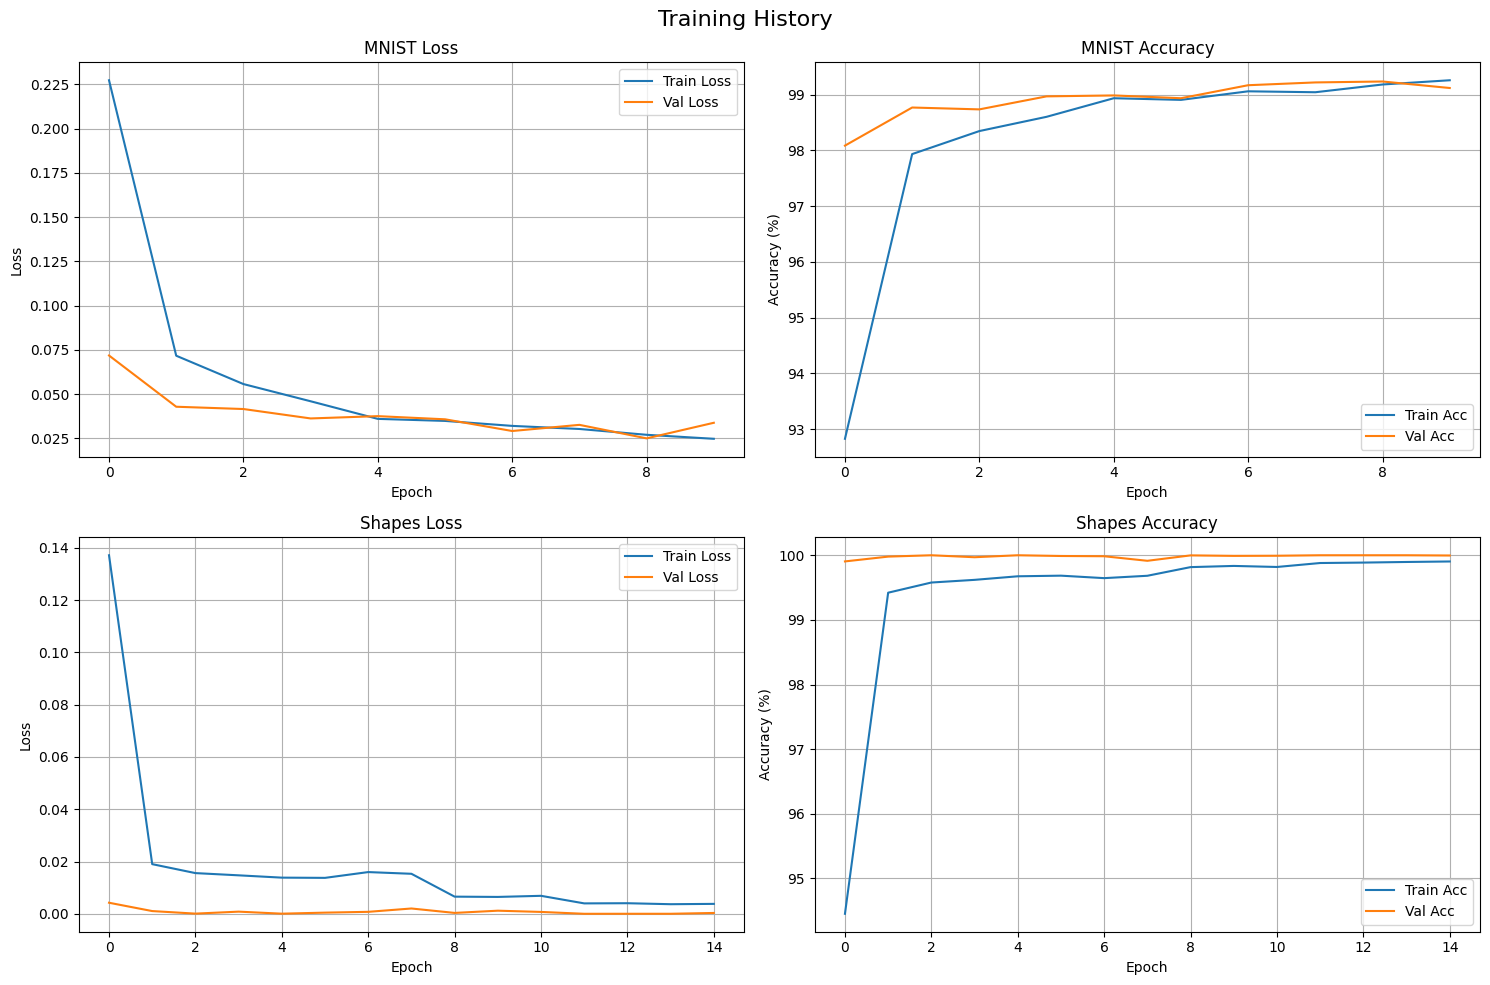

In [87]:
# MNIST History
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training History', fontsize=16)

# MNIST Loss
axes[0, 0].plot(mnist_history['train_loss'], label='Train Loss')
axes[0, 0].plot(mnist_history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('MNIST Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# MNIST Accuracy
axes[0, 1].plot(mnist_history['train_acc'], label='Train Acc')
axes[0, 1].plot(mnist_history['val_acc'], label='Val Acc')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('MNIST Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Shapes Loss
axes[1, 0].plot(shapes_history['train_loss'], label='Train Loss')
axes[1, 0].plot(shapes_history['val_loss'], label='Val Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Shapes Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Shapes Accuracy
axes[1, 1].plot(shapes_history['train_acc'], label='Train Acc')
axes[1, 1].plot(shapes_history['val_acc'], label='Val Acc')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Shapes Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## 13. Predict MNIST Test Set

In [88]:
mnist_model.load_state_dict(torch.load('best_mnist_model.pth'))
mnist_model.eval()
print('Loaded best MNIST model')

mnist_predictions = []
mnist_image_names = []

with torch.no_grad():
    for images, names in tqdm(mnist_test_loader, desc='MNIST Prediction'):
        images = images.to(device)
        outputs = mnist_model(images)
        _, predicted = outputs.max(1)
        
        mnist_predictions.extend(predicted.cpu().numpy())
        mnist_image_names.extend(names)

print(f'Đã dự đoán {len(mnist_predictions)} ảnh MNIST')

Loaded best MNIST model


MNIST Prediction: 100%|██████████████████████████████████████████████████████████████| 157/157 [00:14<00:00, 11.10it/s]

Đã dự đoán 10000 ảnh MNIST


## 14. Tạo file submission MNIST

In [89]:
mnist_submission = pd.DataFrame({
    'image_name': mnist_image_names,
    'label': mnist_predictions
})

mnist_submission = mnist_submission.sort_values('image_name').reset_index(drop=True)
mnist_submission.to_csv('mnist_submission.csv', index=False)

print('Đã lưu file mnist_submission.csv')
print(f'\nNội dung:')
print(mnist_submission.head(10))
print(f'\nPhân bố dự đoán MNIST:')
print(mnist_submission['label'].value_counts().sort_index())

Đã lưu file mnist_submission.csv

Nội dung:
       image_name  label
0  test_00000.png      7
1  test_00001.png      2
2  test_00002.png      1
3  test_00003.png      0
4  test_00004.png      4
5  test_00005.png      1
6  test_00006.png      4
7  test_00007.png      9
8  test_00008.png      5
9  test_00009.png      9

Phân bố dự đoán MNIST:
label
0     979
1    1134
2    1032
3    1019
4     986
5     891
6     954
7    1025
8     974
9    1006
Name: count, dtype: int64


## 15. Visualize kết quả dự đoán

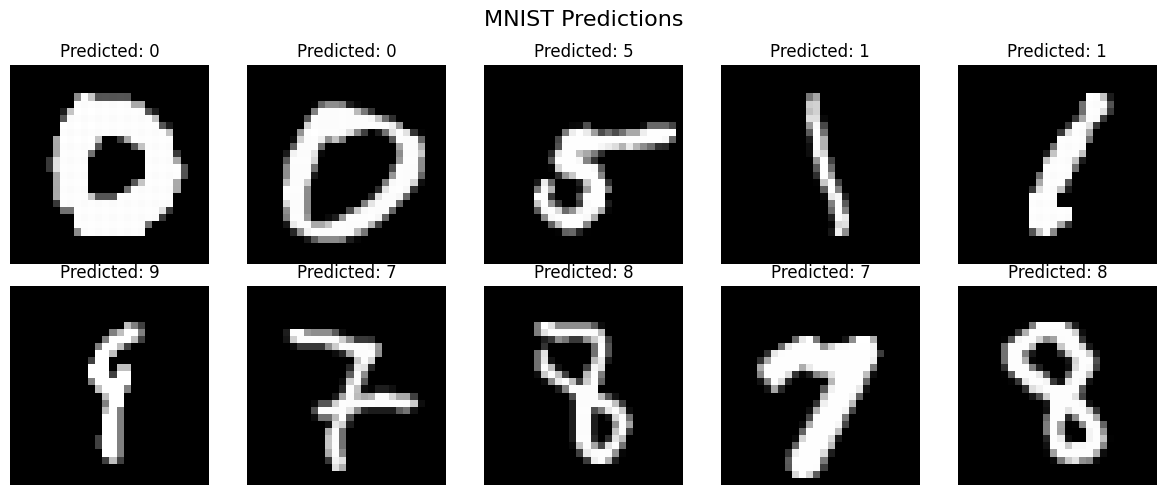

In [90]:
# Visualize MNIST predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('MNIST Predictions', fontsize=16)
axes = axes.ravel()

for i in range(10):
    idx = np.random.randint(len(mnist_submission))
    img_name = mnist_submission.iloc[idx]['image_name']
    pred_label = mnist_submission.iloc[idx]['label']
    
    img_path = os.path.join(MNIST_TEST_DIR, img_name)
    img = Image.open(img_path)
    
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Predicted: {pred_label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

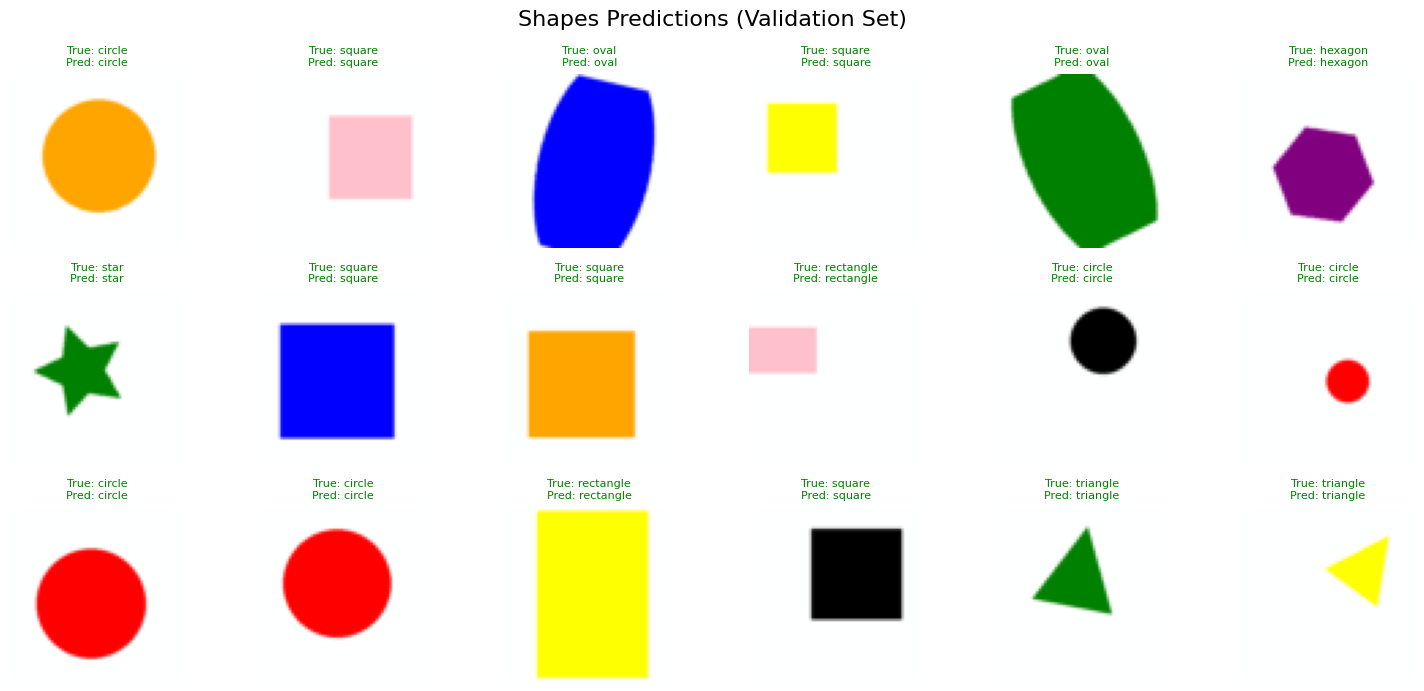

In [91]:
# Visualize Shapes predictions on validation set
shapes_model.load_state_dict(torch.load('best_shapes_model_reduce.pth'))
shapes_model.eval()

fig, axes = plt.subplots(3, 6, figsize=(15, 7))
fig.suptitle('Shapes Predictions (Validation Set)', fontsize=16)
axes = axes.ravel()

sample_indices = np.random.choice(len(shapes_val_dataset), 18, replace=False)

with torch.no_grad():
    for i, idx in enumerate(sample_indices):
        image, true_label = shapes_val_dataset[idx]
        
        # Predict
        image_batch = image.unsqueeze(0).to(device)
        output = shapes_model(image_batch)
        _, predicted = output.max(1)
        pred_label = predicted.item()
        
        # Denormalize for visualization
        img_display = image.permute(1, 2, 0).cpu().numpy()
        img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_display = np.clip(img_display, 0, 1)
        
        axes[i].imshow(img_display)
        color = 'green' if pred_label == true_label else 'red'
        axes[i].set_title(f'True: {SHAPE_CLASSES[true_label]}\nPred: {SHAPE_CLASSES[pred_label]}', 
                         color=color, fontsize=8)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

## 16. Combined Inference Function

In [92]:
def predict_image(image_path, task='mnist'):
    """
    Dự đoán một ảnh đơn lẻ
    task: 'mnist' hoặc 'shapes'
    """
    if task == 'mnist':
        model = mnist_model
        model.load_state_dict(torch.load('best_mnist_model.pth'))
        transform = mnist_test_transform
        image = Image.open(image_path).convert('L')
    else:
        model = shapes_model
        model.load_state_dict(torch.load('best_shapes_model.pth'))
        transform = shapes_test_transform
        image = Image.open(image_path).convert('RGB')
    
    model.eval()
    
    # Transform and predict
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = output.max(1)
        pred_idx = predicted.item()
    
    if task == 'mnist':
        return pred_idx
    else:
        return SHAPE_CLASSES[pred_idx]

print('Combined inference function ready!')
print('\nUsage:')
print("  predict_image('path/to/digit.png', task='mnist')")
print("  predict_image('path/to/shape.png', task='shapes')")

Combined inference function ready!

Usage:
  predict_image('path/to/digit.png', task='mnist')
  predict_image('path/to/shape.png', task='shapes')


## 17. Summary

In [93]:
print('='*60)
print('TRAINING SUMMARY')
print('='*60)
print(f'\nMNIST Model:')
print(f'  - Best Validation Accuracy: {best_mnist_acc:.2f}%')
print(f'  - Model saved: best_mnist_model.pth')
print(f'  - Submission saved: mnist_submission.csv')
print(f'\nShapes Model:')
print(f'  - Best Validation Accuracy: {best_shapes_acc:.2f}%')
print(f'  - Model saved: best_shapes_model.pth')
print(f'  - Number of classes: {len(SHAPE_CLASSES)}')
print('\n' + '='*60)

TRAINING SUMMARY

MNIST Model:
  - Best Validation Accuracy: 99.23%
  - Model saved: best_mnist_model.pth
  - Submission saved: mnist_submission.csv

Shapes Model:
  - Best Validation Accuracy: 100.00%
  - Model saved: best_shapes_model.pth
  - Number of classes: 7

